<style>
@import url(https://www.numfys.net/static/css/nbstyle.css);
</style>
<a href="https://www.numfys.net"><img class="logo" /></a>

# Euler Equations for Inviscid Flow

### Examples - Fluid Mechanics
<section class="post-meta">
By Knut Sverdrup, October 2016
</section>
Last edited: March 22nd 2018
___

## Introduction 

This notebook is an introduction to a set of partial differential equations which are widely used to model aerodynamics, atmosphere and climate, explosive detonations and even astrophysics. It only gives a small taste of the world of hyperbolic PDEs, Riemann problems and computational fluid dynamics, and the interested reader is encouraged to investigate the field further [1]. 

The Euler equations govern adiabatic and inviscid flow of a fluid. In the Froude limit (no external body forces) in one dimension, with density $\rho$, velocity $u$, total energy $E$ and pressure $p$, they are given in dimensionless form as

\begin{align*}
    \frac{\partial \rho}{\partial t} + \frac{\partial (\rho u)}{\partial x} &= 0, \\
    \frac{\partial (\rho u)}{\partial t} + \frac{\partial (\rho u^2 + p)}{\partial x} &= 0, \\
    \frac{\partial (\rho E)}{\partial t} + \frac{\partial u(E + p)}{\partial x} &= 0.
\end{align*}

These three equations describe conservation of mass, momentum and energy, respectively.
In order to solve them numerically, we start by importing NumPy and setting up the plotting environment. 

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [2]:
newparams = {'font.size': 14, 'figure.figsize': (14, 7),
             'mathtext.fontset': 'stix', 'font.family': 'STIXGeneral',
             'lines.linewidth': 2}
plt.rcParams.update(newparams)

## Ideal gases


For an ideal gas, the total energy is the sum of the kinetic and potential contributions, i.e. 

\begin{equation*}
    E = \frac{1}{2} \rho u^2 + \frac{p}{\gamma - 1}, 
\end{equation*}

where $\gamma$ is the ratio of specific heats for the material in our system. We shall be considering air, which has $\gamma = 1.4$. Note that $e = \frac{p}{(\gamma - 1)\rho}$ is the specific internal energy for ideal gases. Conversions between energy and pressure will be useful to us later, so we define appropriate functions:

In [3]:
def energy(rho, u, p):
    return 0.5 * rho * u ** 2 + p / 0.4 

def pressure(rho, u, E):
    return 0.4 * (E - 0.5 * rho * u ** 2)

## Conservation laws

Conveniently, this first-order hyperbolic system of PDEs can be written as a set of conservation laws, i.e.

\begin{equation*}
    \partial_t {\bf Q} + \partial_x {\bf F(Q)} = {\bf 0}\,.
\end{equation*}

Here, the vector of conserved quantities ${\bf Q}$ and their fluxes ${\bf F(Q)}$ are given by

\begin{equation*}
    {\bf Q} = 
    \begin{bmatrix} 
        \rho \\ 
        \rho u \\ 
        E 
    \end{bmatrix}
    \,,\quad
    {\bf F} = 
    \begin{bmatrix}
        \rho u \\ 
        \rho u^2 + p \\
        u(E+p) 
    \end{bmatrix}
    \,.
\end{equation*}

Given the state of the system (i.e. the vector of conserved quantities), we compute the flux as: 

In [4]:
def flux(Q):
    rho, u, E = Q[0], Q[1] / Q[0], Q[2]
    p = pressure(rho, u, E)
    F = np.empty_like(Q)
    F[0] = rho * u
    F[1] = rho * u ** 2 + p
    F[2] = u * (E + p)
    return F

## Finite volumes

Consider a spatial domain $[x_L, x_R]$ and two points in time $t_2 > t_1$. By integrating the Euler equations in differential form in space and time, we acquire the integral form, 

\begin{equation*}
    \int_{x_L}^{x_R} {\bf Q}(x, t_2) {\rm d} x = \int_{x_L}^{x_R} {\bf Q}(x, t_1) {\rm d} x 
    + \int_{t_1}^{t_2} {\bf F}({\bf Q}(x_L, t)) {\rm d} t - \int_{t_1}^{t_2} {\bf F}({\bf Q}(x_R, t)) {\rm d} t .
\end{equation*}

This relation is the basis for our spatial and temporal discretisations. For simplicity, we take our computational domain to be $[0, 1]$, and divide it into $N$ equal cells of width $\Delta x = 1/N$: 

In [5]:
N = 100
dx = 1 / N
x = np.linspace(-0.5 * dx, 1 + 0.5 * dx, N + 2)

Note that we have added one extra cell to each side of the domain. These are so-called ghost cells which allow us to apply appropriate boundary conditions (more on that shortly). It is also necessary to discretise the state vector $\bf Q$ and intercell fluxes $\bf F$. We denote by ${\bf Q}_i^n$ the spatial average within the cell $[x_{i-1/2}, x_{i+1/2}]$ at time $t_n$, i.e.

\begin{equation*} 
    {\bf Q}_i^n = \frac{1}{\Delta x} \int_{x_{i-1/2}}^{x_{i+1/2}} {\bf Q}(x, t_n) {\rm d} x ,
\end{equation*}

and initialise a numpy array to store the values within each cell: 

In [6]:
Q = np.empty((3, len(x))) 

Similarly, the temporal average of the flux across the cell boundary at $x_{i+1/2}$ is denoted ${\bf F}_{i+1/2}^n$: 

\begin{equation*}
    {\bf F}_{i+1/2}^n = \frac{1}{\Delta t^n} \int_{t_n}^{t_{n+1}} {\bf F}({\bf Q}(x_{i+1/2}, t)) {\rm d} t .
\end{equation*}

Inserting these discretisations into the integral form of the Euler equations, we get a conservative update formula for each computational cell which is $exact$: 

\begin{equation*}
    {\bf Q}_i^{n+1} = {\bf Q}_i^n + 
    \frac{\Delta t^n}{\Delta x} \left( {\bf F}_{i-\frac{1}{2}}^n - {\bf F}_{i+\frac{1}{2}}^n \right) 
\end{equation*}

This formula is our method for advancing the system forwards in time, and the numerical approximations are solely in the evaluations of the intercell fluxes ${\bf F}_{i \pm 1/2}^n$. We cannot, however, choose the time step $\Delta t^n$ as large as we want, due to restrictions on stability. By choosing a Courant-Friedrichs-Lewis (CFL) coefficient $c \leq 1$, the time step can safely be set to

\begin{equation*}
    \Delta t^n = \frac{c \Delta x}{S_{\rm max}^n}, 
\end{equation*}

where $S_{\rm max}^n$ is a measure of the maximum wave speed present in the system. We use a common approximation which finds the cell with highest sum of material and sound speeds, i.e. 

\begin{equation*}
    S_{\rm max}^n = \max_i ( |u_i^n| + a_i^n ) , 
\end{equation*}

where the speed of sound for ideal gases is given by 

\begin{equation*}
    a = \sqrt{\frac{\gamma p}{\rho}} .
\end{equation*}

In [7]:
def timestep(Q, c, dx):
    rho, u, E = Q[0], Q[1] / Q[0], Q[2]
    
    a = np.sqrt(1.4 * pressure(rho, u, E) / rho)
    S_max = np.max(np.abs(u) + a)
    
    return  c * dx / S_max

## FORCE scheme for flux approximations

Many different procedures exist for approximating the intercell fluxes ${\bf F}_{i \pm 1/2}$. For simplicity, we implement the relatively straight-forward FIrst-ORder CEntred (FORCE) scheme. [2] Given the state of two neighbouring cells, the FORCE flux at the interface is computed as

\begin{equation*}
    {\bf F}_{\rm FORCE} ({\bf Q}_L, {\bf Q}_R) 
        =\frac{1}{2} \left( {\bf F}_0 + \frac{1}{2} ({\bf F}_L + {\bf F}_R) \right) + \frac{1}{4} \frac{\Delta x}{\Delta t^n} ({\bf Q}_L - {\bf Q}_R) . 
\end{equation*}

Here, ${\bf F}_K = {\bf F}({\bf Q}_K)$ and 

\begin{equation*}
    {\bf Q}_0 = \frac{1}{2} ({\bf Q}_L + {\bf Q}_R) + \frac{1}{2} \frac{\Delta t^n}{\Delta x} ({\bf F}_L- {\bf F}_R) , 
\end{equation*}

These equations correspond to Eqns. (16) and (19) in [2]. 

At this point, the reason for our previously introduced ghost cells become apparent. Since each cell interface requires information from both sides, the first and $N$-th cells in our domain lack information from the left and right, respectively. By initialising a ghost cell on each side and transmitting information from within the domain outwards for each time step, these fictional cells provide the necessary information for performing our computations. 

Implementing the force scheme in Python, we have 

In [8]:
def force(Q):
    Q_L = Q[:, :-1]
    Q_R = Q[:, 1:]
    
    F_L = flux(Q_L)
    F_R = flux(Q_R)
    
    Q_0 = 0.5 * (Q_L + Q_R) + 0.5 * dt / dx * (F_L - F_R) 
    F_0 = flux(Q_0)
    
    return 0.5 * (F_0 + 0.5 * (F_L + F_R)) + 0.25 * dx / dt * (Q_L - Q_R)

## Sod's shock tube

Given an initial condition ${\bf Q}(x, 0)$, we want to evolve the system in time to predict the 
state at some future time $t=T$. A popular test case for the Euler equations is Sod's shock tube. The test consists of a Riemann problem, which means that the PDE is coupled with a set of piecewise constant initial conditions separated by a single discontinuity. Intuitively, the test can be thought of as a tube with a membrane separating air of two different densities (and pressures). At $t=0$, the membrane is removed, which results in a rarefaction wave, a contact discontinuity and a shock wave. The initial conditions are given by

\begin{equation*}
    {\bf Q}(x, 0) = 
        \begin{cases} 
            {\bf Q}_L \quad {\rm if} \quad x \leq 0.5 \\ 
            {\bf Q}_R \quad {\rm if} \quad x > 0.5 
        \end{cases} , \quad 
    \begin{pmatrix} \rho \\ u \\ p \end{pmatrix}_L 
    = \begin{pmatrix} 1 \\ 0 \\ 1 \end{pmatrix} , \quad
    \begin{pmatrix} \rho \\ u \\ p \end{pmatrix}_R
    = \begin{pmatrix} 0.125 \\ 0 \\ 0.1 \end{pmatrix} .
\end{equation*}

We therefore initialise the vector of conserved variables according to 

In [9]:
# Density: 
Q[0, x <= 0.5] = 1.0
Q[0, x > 0.5] = 0.125
# Momentum: 
Q[1] = 0.0
# Energy: 
Q[2, x <= 0.5] = energy(1.0, 0.0, 1.0)
Q[2, x > 0.5] = energy(0.125, 0.0, 0.1)

## Evolution of the system

All prerequisites are now in place for us to evolve the shock tube system in time numerically. We choose a CFL-coefficient of 0.95, and advance to a final time $T=0.25$

In [10]:
c = 0.9
T = 0.25
t = 0
while t < T:
    # Compute time step size
    dt = timestep(Q, c, dx)
    if t + dt > T: # Make sure to end up at specified final time
        dt = T - t

    # Transmissive boundary conditions
    Q[:, 0] = Q[:, 1] # Left boundary 
    Q[:, N + 1] = Q[:, N] # Right boundary

    # Flux computations using FORCE scheme
    F = force(Q)

    # Conservative update formula
    Q[:, 1:-1] += dt / dx * (F[:, :-1] - F[:, 1:]) 
    
    # Go to next time step
    t += dt

## Results

In order to compare our results, an exact reference solution is provided in the file "ref.txt". For the simple case of a single contact discontinuity, this Riemann problem can be solved up to arbitrary accuracy with an exact (iterative) solver. The implementation of the exact solver is outside the scope of this notebook, but the interested reader is referred to the extensive resource by Toro [1]. 

In [11]:
# Load reference solution
ref_sol = np.loadtxt('ref.txt')
ref_sol = np.transpose(ref_sol)

# Numerical results for density, velocity, pressure and internal energy
num_sol = [Q[0], Q[1] / Q[0], pressure(Q[0], Q[1] / Q[0], Q[2]), \
    pressure(Q[0], Q[1] / Q[0], Q[2]) / (0.4 * Q[0])]

With the reference solution in place, we can make plots of how density, velocity, pressure and internal energy are distributed throughout the domain at the final time $t = T$. 

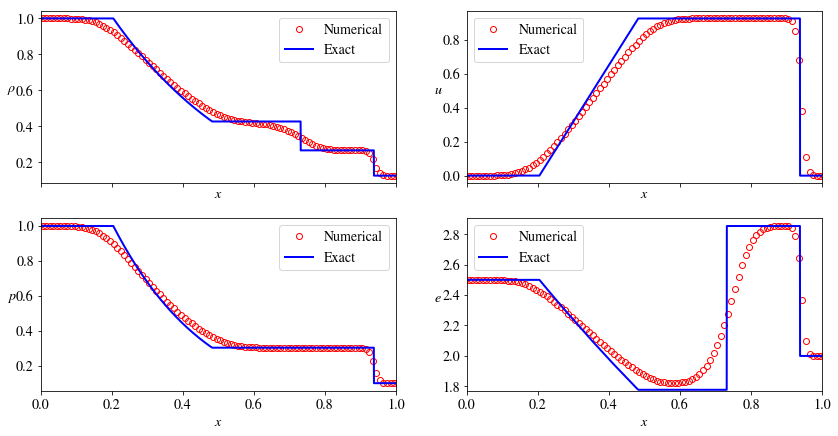

In [12]:
fig, axes = plt.subplots(2, 2, sharex='col', num=1)
axes = axes.flatten()
labels = [r'$\rho$', r'$u$', r'$p$', r'$e$']

# For each subplot, plot numerical and exact solutions
for ax, label, num, ref in zip(axes, labels, num_sol, ref_sol[1:]): 
    ax.plot(x, num, 'or', fillstyle='none', label='Numerical')
    ax.plot(ref_sol[0], ref, 'b-', label='Exact')
    ax.set_xlim([0, 1])
    ylim_offset = 0.05 * (np.max(num) - np.min(num))
    ax.set_ylim([np.min(num) - ylim_offset , np.max(num) + ylim_offset])
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(label, rotation=0)
    ax.legend(loc='best')
plt.show()

Going from left to right in the domain, it is clear that our scheme has resolved the rarefaction wave, contact discontinuity (evident in $\rho$ and $e$) and the shock wave. Compared to the exact solution, however, it is obvious that the numerical approximation is diffused and fails to capture sharp discontinuities accurately. This inaccuracy is as expected for a scheme which is only first-order accurate, since the second-order error term is diffusive by nature. Every time we advance the system in time, the numerical solution gets slightly smeared out compared to the exact one. After 60 time steps, the result is as shown. For any serious applications, high-resolution schemes with at least second order accuracy should be considered. A few such schemes are given in [3]. 

## Further questions

* How can you modify the code to figure out how many steps were necessary to reach $t=T$? 
* Try increasing $N$ - are the results as you would expect? How does this affect the number of iterations? 
* What is the effect of altering the CFL coefficient? Is there an optimal value? 
* Check out how animations are used in the NumFys example on [Planetary motion](https://nbviewer.jupyter.org/urls/www.numfys.net/media/notebooks/planetary_motion_three_body_problem.ipynb). Can you use the same techniques to animate our results from the initial time until the end state? 
* The [Wikipedia page](https://en.wikipedia.org/wiki/Sod_shock_tube) for the Sod shock tube explains briefly the analytical solution which is given as a reference. How would you go about implementing an exact solver in Python? 


## References

[1] E. F. Toro: "Riemann Solvers and Numerical Methods for Fluid Dynamics - A Practical Introduction" (3rd ed, Springer, 2009)

[2] E. F. Toro & A. Hidalgo & M. Dumbser: "FORCE schemes on unstructured meshes I: Conservative hyperbolic systems" (Journal of Computational Physics, 2009)

[3] E. F. Toro & S. J. Billett: "Centred TVD Schemes for Hyperbolic Conservation Laws" (IMA Journal of Numerical Analysis, 2000)